In [1]:
# Import des librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re # Pour les expressions régulières
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import os # Pour gérer les chemins de fichiers

In [2]:
# --- Configuration de l'affichage de pandas ---
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200) # Pour voir plus de texte dans les colonnes
pd.set_option('display.width', 1000)

print("--- Projet NLP : Analyse de Sentiment Avancée (AeroPulse Corp.) ---")
print("--- Phase 2 : Préparation Initiale des Données Textuelles ---")

# --- INITIALISATION ET TÉLÉCHARGEMENT DES RESSOURCES NLTK (CE BLOC EST CRUCIAL !) ---
# Ce bloc doit être exécuté au début du notebook.
# Si vous avez déjà téléchargé toutes les ressources via nltk.download('all') ou de manière ciblée,
# et que votre kernel a été redémarré, ces lignes ne devraient rien retélécharger.
# Mais elles s'assurent que NLTK sait où chercher les ressources.

# Chemin personnalisé pour les données NLTK (utilisez le même chemin que vous avez configuré précédemment)
# C'est le dossier 'nltk_data' que vous avez créé dans votre dossier de projet.
current_notebook_dir = os.getcwd()
custom_nltk_data_path = os.path.join(current_notebook_dir, "nltk_data")

# Assurez-vous que NLTK utilise ce chemin en priorité
nltk.data.path.insert(0, custom_nltk_data_path)
print(f"Chemins de recherche NLTK configurés : {nltk.data.path}")

# Liste des ressources NLTK nécessaires
required_nltk_resources = [
    'punkt',     # Pour word_tokenize
    'stopwords', # Pour la suppression des mots vides
    'wordnet',   # Pour la lemmatisation
    'omw-1.4'    # Dépendance de wordnet
]

print("\n--- Vérification et chargement des ressources NLTK ---")
for resource in required_nltk_resources:
    try:
        # Tente de trouver la ressource. Si non trouvée, déclenche une LookupError.
        # Le chemin de ressource varie ('tokenizers/' ou 'corpora/')
        if resource == 'punkt':
            nltk.data.find(f'tokenizers/{resource}')
        else:
            nltk.data.find(f'corpora/{resource}')
        print(f"Ressource '{resource}' déjà trouvée.")
    except LookupError:
        print(f"La ressource '{resource}' n'a pas été trouvée, tentative de téléchargement...")
        try:
            nltk.download(resource, download_dir=custom_nltk_data_path, quiet=False)
            print(f"Ressource '{resource}' téléchargée avec succès.")
        except Exception as e:
            print(f"ERREUR lors du téléchargement de '{resource}': {e}")
            print("Vérifiez votre connexion internet ou les permissions d'écriture.")
            print("Poursuite du script sans cette ressource (peut causer des erreurs plus tard).")


print("\n--- Initialisation NLTK Complétée (au début du script) ---")




--- Projet NLP : Analyse de Sentiment Avancée (AeroPulse Corp.) ---
--- Phase 2 : Préparation Initiale des Données Textuelles ---
Chemins de recherche NLTK configurés : ['c:\\Users\\pc\\Desktop\\Projet_Data_science\\AeroPulse_Corp\\Code\\nltk_data\\nltk_data', 'C:\\Users\\pc/nltk_data', 'c:\\Users\\pc\\anacond\\nltk_data', 'c:\\Users\\pc\\anacond\\share\\nltk_data', 'c:\\Users\\pc\\anacond\\lib\\nltk_data', 'C:\\Users\\pc\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']

--- Vérification et chargement des ressources NLTK ---
Ressource 'punkt' déjà trouvée.
Ressource 'stopwords' déjà trouvée.
La ressource 'wordnet' n'a pas été trouvée, tentative de téléchargement...


[nltk_data] Downloading package wordnet to c:\Users\pc\Desktop\Projet_
[nltk_data]     Data_science\AeroPulse_Corp\Code\nltk_data\nltk_data..
[nltk_data]     .


Ressource 'wordnet' téléchargée avec succès.
La ressource 'omw-1.4' n'a pas été trouvée, tentative de téléchargement...


[nltk_data] Downloading package omw-1.4 to c:\Users\pc\Desktop\Projet_
[nltk_data]     Data_science\AeroPulse_Corp\Code\nltk_data\nltk_data..
[nltk_data]     .


Ressource 'omw-1.4' téléchargée avec succès.

--- Initialisation NLTK Complétée (au début du script) ---


In [3]:
# --- Étape A : Chargement du Dataset ---

# Le fichier tweets.csv n'a pas toujours un encodage UTF-8 standard.
# Il est courant d'essayer 'latin1' ou 'ISO-8859-1' pour ce type de fichiers.
try:
    df_tweets = pd.read_csv('../../nlp_project/tweets.csv', encoding='latin1')
    print("\nDataset 'tweets.csv' chargé avec succès !")
    print(f"Dimensions initiales du dataset : {df_tweets.shape}")
except FileNotFoundError:
    print("Erreur : Le fichier 'tweets.csv' n'a pas été trouvé.")
    print("Assurez-vous qu'il se trouve dans le dossier 'nlp_project'.")
    exit()
except UnicodeDecodeError:
    print("Erreur d'encodage. Essayez un autre encodage si 'latin1' échoue.")
    exit()




Dataset 'tweets.csv' chargé avec succès !
Dimensions initiales du dataset : (14640, 15)


In [4]:
# --- Étape B : Compréhension Initiale des Données ---

print("\n--- Aperçu des 5 premières lignes du dataset ---")
print(df_tweets.head())

print("\n--- Informations générales sur le dataset (types de données, valeurs non nulles) ---")
df_tweets.info()

print("\n--- Statistiques descriptives pour les colonnes numériques (s'il y en a) ---")
print(df_tweets.describe(include='all')) # 'include=all' pour voir aussi les stats des colonnes object




--- Aperçu des 5 premières lignes du dataset ---
             tweet_id airline_sentiment  airline_sentiment_confidence negativereason  negativereason_confidence         airline airline_sentiment_gold        name negativereason_gold  retweet_count                                                                                                                            text tweet_coord              tweet_created tweet_location               user_timezone
0  570306133677760513           neutral                        1.0000            NaN                        NaN  Virgin America                    NaN     cairdin                 NaN              0                                                                                             @VirginAmerica What @dhepburn said.         NaN  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)
1  570301130888122368          positive                        0.3486            NaN                     0.0000  Virgin America       

In [5]:
# --- Étape C : Vérification et Gestion des Valeurs Manquantes ---

print("\n--- Vérification des valeurs manquantes par colonne ---")
missing_data = df_tweets.isnull().sum()
print(missing_data[missing_data > 0])

# Pour la colonne 'text' (qui contient le tweet), nous allons supprimer les NaN s'il y en a.
# C'est crucial car un modèle NLP ne peut pas traiter un NaN comme du texte.
initial_rows = df_tweets.shape[0]
df_tweets.dropna(subset=['text'], inplace=True) # Supprime les lignes où 'text' est NaN
print(f"Lignes avec NaN dans 'text' supprimées. Nouvelles dimensions : {df_tweets.shape}")





--- Vérification des valeurs manquantes par colonne ---
negativereason                5462
negativereason_confidence     4118
airline_sentiment_gold       14600
negativereason_gold          14608
tweet_coord                  13621
tweet_location                4733
user_timezone                 4820
dtype: int64
Lignes avec NaN dans 'text' supprimées. Nouvelles dimensions : (14640, 15)


In [6]:
# --- Étape D : Vérification et Gestion des Doublons ---

print("\n--- Vérification des doublons sur la colonne 'text' ---")
initial_rows_dedup = df_tweets.shape[0]
df_tweets.drop_duplicates(subset=['text'], inplace=True)
print(f"Doublons sur la colonne 'text' supprimés. Nouvelles dimensions : {df_tweets.shape}")
print(f"Nombre de doublons supprimés : {initial_rows_dedup - df_tweets.shape[0]}")





--- Vérification des doublons sur la colonne 'text' ---
Doublons sur la colonne 'text' supprimés. Nouvelles dimensions : (14427, 15)
Nombre de doublons supprimés : 213



--- Exploration approfondie de 'airline_sentiment' ---


C:\Users\pc\AppData\Local\Temp\ipykernel_22060\26003922.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=df_tweets, palette='viridis')


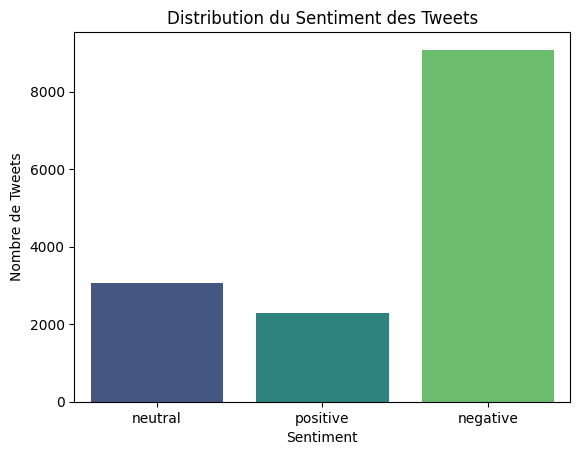

In [7]:
# --- Étape E : Première Exploration de la Variable Cible ---

print("\n--- Exploration approfondie de 'airline_sentiment' ---")
sns.countplot(x='airline_sentiment', data=df_tweets, palette='viridis')
plt.title('Distribution du Sentiment des Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de Tweets')
plt.show()




In [8]:
# --- Étape F : NETTOYAGE SPÉCIFIQUE AU TEXTE (Pré-traitement NLP) ---

print("\n--- Étape F : Nettoyage Spécifique au Texte ---")

# 1. Conversion en Minuscules (Lowercase)
df_tweets['cleaned_text'] = df_tweets['text'].str.lower()

# 2. Suppression de la Ponctuation, des Chiffres et des Caractères Spéciaux
def clean_punctuation_numbers(text):
    # Assurez-vous que le texte est une chaîne de caractères
    if pd.isna(text):
        return ""
    text = re.sub(r'[^a-z\s]', '', text)
    return text

df_tweets['cleaned_text'] = df_tweets['cleaned_text'].apply(clean_punctuation_numbers)

# 3. Suppression des URLs (liens web)
def remove_urls(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'http\S+|www.\S+', '', text)
    return text

df_tweets['cleaned_text'] = df_tweets['cleaned_text'].apply(remove_urls)

# 4. Suppression des Mentions (@usernames) et Hashtags (#hashtags)
def remove_mentions_hashtags(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'@\S+|#\S+', '', text)
    return text

df_tweets['cleaned_text'] = df_tweets['cleaned_text'].apply(remove_mentions_hashtags)


# 5. Suppression des Espaces Multiples et des Espaces en Trop
df_tweets['cleaned_text'] = df_tweets['cleaned_text'].str.strip() # Enlève les espaces au début/fin
df_tweets['cleaned_text'] = df_tweets['cleaned_text'].str.replace(r'\s+', ' ', regex=True) # Remplace multiples espaces par un seul


print("\nTexte nettoyé après étapes F. Exemple :")
print(df_tweets[['text', 'cleaned_text']].head())





--- Étape F : Nettoyage Spécifique au Texte ---

Texte nettoyé après étapes F. Exemple :
                                                                                                                             text                                                                                                             cleaned_text
0                                                                                             @VirginAmerica What @dhepburn said.                                                                                         virginamerica what dhepburn said
1                                                        @VirginAmerica plus you've added commercials to the experience... tacky.                                                       virginamerica plus youve added commercials to the experience tacky
2                                                         @VirginAmerica I didn't today... Must mean I need to take another trip!                            

In [9]:
# --- Étape G : Tokenisation ---
from nltk.tokenize import word_tokenize # Déjà importé en haut, mais pour la clarté

df_tweets['tokens'] = df_tweets['cleaned_text'].apply(word_tokenize)
print("\nTexte tokenisé. Exemple :")
print(df_tweets[['cleaned_text', 'tokens']].head())





Texte tokenisé. Exemple :
                                                                                                              cleaned_text                                                                                                                                     tokens
0                                                                                         virginamerica what dhepburn said                                                                                                      [virginamerica, what, dhepburn, said]
1                                                       virginamerica plus youve added commercials to the experience tacky                                                               [virginamerica, plus, youve, added, commercials, to, the, experience, tacky]
2                                                        virginamerica i didnt today must mean i need to take another trip                                                             [vir

In [10]:
# --- Étape H : Suppression des Stop Words ---
from nltk.corpus import stopwords # Déjà importé en haut

stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    # Gérer le cas où 'tokens' est None ou vide
    if not tokens:
        return []
    return [word for word in tokens if word not in stop_words]

df_tweets['tokens_no_stopwords'] = df_tweets['tokens'].apply(remove_stopwords)
print("\nStop words supprimés. Exemple :")
print(df_tweets[['tokens', 'tokens_no_stopwords']].head())





Stop words supprimés. Exemple :
                                                                                                                                      tokens                                                                                         tokens_no_stopwords
0                                                                                                      [virginamerica, what, dhepburn, said]                                                                             [virginamerica, dhepburn, said]
1                                                               [virginamerica, plus, youve, added, commercials, to, the, experience, tacky]                                         [virginamerica, plus, youve, added, commercials, experience, tacky]
2                                                             [virginamerica, i, didnt, today, must, mean, i, need, to, take, another, trip]                                        [virginamerica, didnt, today, must, mean

In [11]:
# --- Étape I : Lemmatisation ---
from nltk.stem import WordNetLemmatizer # Déjà importé en haut

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    # Gérer le cas où 'tokens' est None ou vide
    if not tokens:
        return []
    return [lemmatizer.lemmatize(word) for word in tokens]

df_tweets['lemmatized_tokens'] = df_tweets['tokens_no_stopwords'].apply(lemmatize_tokens)
print("\nTexte lemmatisé. Exemple :")
print(df_tweets[['tokens_no_stopwords', 'lemmatized_tokens']].head())


print("\n--- Préparation Avancée des Données Textuelles Terminée ---")
print(f"Aperçu final des colonnes de texte préparées :\n{df_tweets[['text', 'cleaned_text', 'lemmatized_tokens']].head()}")
print(f"Dimensions finales du dataset après préparation : {df_tweets.shape}")


Texte lemmatisé. Exemple :
                                                                                          tokens_no_stopwords                                                                                         lemmatized_tokens
0                                                                             [virginamerica, dhepburn, said]                                                                           [virginamerica, dhepburn, said]
1                                         [virginamerica, plus, youve, added, commercials, experience, tacky]                                        [virginamerica, plus, youve, added, commercial, experience, tacky]
2                                        [virginamerica, didnt, today, must, mean, need, take, another, trip]                                      [virginamerica, didnt, today, must, mean, need, take, another, trip]
3  [virginamerica, really, aggressive, blast, obnoxious, entertainment, guests, faces, amp, little, recourse

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay

In [15]:
# --- DEBUT DU BLOC DE VECTORISATION (qui crée 'vectorizer' et 'tfidf_matrix') ---
print("\n--- Phase 3 : Vectorisation du Texte avec TF-IDF ---")

# 1. Rejoindre les tokens pour former une chaîne de caractères (texte) pour chaque document
df_tweets['processed_text_for_vectorizer'] = df_tweets['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

print("\nTexte préparé pour le vectoriseur (tokens joints) :")
print(df_tweets[['lemmatized_tokens', 'processed_text_for_vectorizer']].head())





--- Phase 3 : Vectorisation du Texte avec TF-IDF ---

Texte préparé pour le vectoriseur (tokens joints) :
                                                                                          lemmatized_tokens                                                                 processed_text_for_vectorizer
0                                                                           [virginamerica, dhepburn, said]                                                                   virginamerica dhepburn said
1                                        [virginamerica, plus, youve, added, commercial, experience, tacky]                                    virginamerica plus youve added commercial experience tacky
2                                      [virginamerica, didnt, today, must, mean, need, take, another, trip]                                    virginamerica didnt today must mean need take another trip
3  [virginamerica, really, aggressive, blast, obnoxious, entertainment, guest, face, 

In [16]:
# 2. Instancier le TfidfVectorizer (CRÉATION DE 'vectorizer')
vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)



In [17]:
# 3. Entraîner le vectoriseur (fit) et transformer le texte (transform) (CRÉATION DE 'tfidf_matrix')
tfidf_matrix = vectorizer.fit_transform(df_tweets['processed_text_for_vectorizer'])

print(f"\nMatrice TF-IDF créée. Dimensions : {tfidf_matrix.shape}")
print(f"Exemple des 10 premiers mots du vocabulaire appris : {vectorizer.get_feature_names_out()[:10]}")

print("\n--- Vectorisation TF-IDF Terminée ---")
# --- FIN DU BLOC DE VECTORISATION ---





Matrice TF-IDF créée. Dimensions : (14427, 2587)
Exemple des 10 premiers mots du vocabulaire appris : ['aa' 'aadvantage' 'abc' 'ability' 'able' 'abq' 'absolute' 'absolutely'
 'absurd' 'abt']

--- Vectorisation TF-IDF Terminée ---


In [18]:
# --- DEBUT DU BLOC DE MODÉLISATION (qui utilise 'vectorizer' et 'tfidf_matrix') ---
print("\n--- Phase 3 (Suite) : Modélisation avec TF-IDF et LightGBM Classifier ---")

# 1. Préparation de la Variable Cible ('airline_sentiment')
# Simplifions le problème : 'negative' (1) vs 'non-negative' (0)
df_tweets['binary_sentiment'] = df_tweets['airline_sentiment'].apply(
    lambda x: 1 if x == 'negative' else 0
)

print("\nDistribution de la variable cible binaire 'binary_sentiment' :")
print(df_tweets['binary_sentiment'].value_counts(normalize=True))




--- Phase 3 (Suite) : Modélisation avec TF-IDF et LightGBM Classifier ---

Distribution de la variable cible binaire 'binary_sentiment' :
binary_sentiment
1    0.629375
0    0.370625
Name: proportion, dtype: float64


In [19]:
# 2. Séparation des Caractéristiques (X) et de la Variable Cible (y)
X = tfidf_matrix # tfidf_matrix est maintenant défini
y = df_tweets['binary_sentiment']

print(f"\nDimensions de X (matrice TF-IDF) : {X.shape}")
print(f"Dimensions de y (cible binaire) : {y.shape}")




Dimensions de X (matrice TF-IDF) : (14427, 2587)
Dimensions de y (cible binaire) : (14427,)


In [20]:
# 3. Division du Dataset en Ensembles d'Entraînement et de Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nDimensions des ensembles après split :")
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test : {X_test.shape}, y_test : {y_test.shape}")




Dimensions des ensembles après split :
X_train : (11541, 2587), y_train : (11541,)
X_test : (2886, 2587), y_test : (2886,)


In [21]:
# 4. Entraînement du Modèle LightGBM Classifier
print("\n--- Entraînement du Modèle LightGBM Classifier pour le Sentiment ---")

lgb_sentiment_model = lgb.LGBMClassifier(objective='binary',
                                         metric='binary_logloss',
                                         n_estimators=1000,
                                         learning_rate=0.05,
                                         num_leaves=31,
                                         max_depth=-1,
                                         min_child_samples=20,
                                         subsample=0.8,
                                         colsample_bytree=0.8,
                                         random_state=42,
                                         n_jobs=-1,
                                         class_weight='balanced')

lgb_sentiment_model.fit(X_train, y_train,
                        eval_set=[(X_test, y_test)],
                        eval_metric='binary_logloss',
                        callbacks=[lgb.early_stopping(100, verbose=False)])

print("\nModèle LightGBM Classifier pour le sentiment entraîné avec succès !")




--- Entraînement du Modèle LightGBM Classifier pour le Sentiment ---
[LightGBM] [Info] Number of positive: 7264, number of negative: 4277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25937
[LightGBM] [Info] Number of data points in the train set: 11541, number of used features: 819
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

Modèle LightGBM Classifier pour le sentiment entraîné avec succès !



--- Évaluation du Modèle LightGBM Classifier pour le Sentiment ---

Rapport de Classification :
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      1070
           1       0.88      0.82      0.85      1816

    accuracy                           0.82      2886
   macro avg       0.81      0.82      0.81      2886
weighted avg       0.82      0.82      0.82      2886


Matrice de Confusion :
[[ 868  202]
 [ 322 1494]]


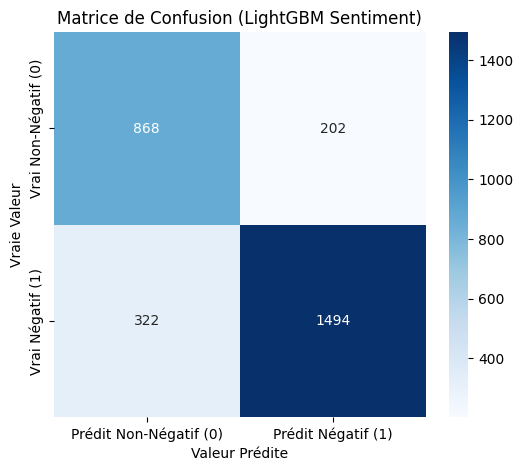


Score AUC-ROC : 0.8997


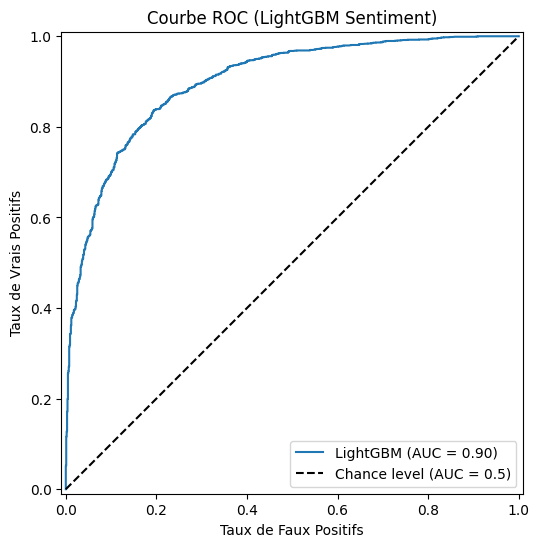

Score PR-AUC (Average Precision) : 0.9358


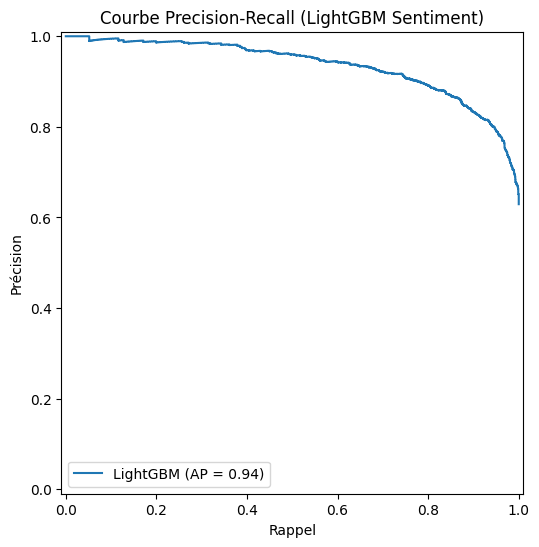


--- Modélisation avec TF-IDF et LightGBM Terminée ---


In [22]:
# 5. Prédiction et Évaluation du Modèle
print("\n--- Évaluation du Modèle LightGBM Classifier pour le Sentiment ---")

y_pred = lgb_sentiment_model.predict(X_test)
y_pred_proba = lgb_sentiment_model.predict_proba(X_test)[:, 1]

print("\nRapport de Classification :")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nMatrice de Confusion :")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prédit Non-Négatif (0)', 'Prédit Négatif (1)'],
            yticklabels=['Vrai Non-Négatif (0)', 'Vrai Négatif (1)'])
plt.title('Matrice de Confusion (LightGBM Sentiment)')
plt.ylabel('Vraie Valeur')
plt.xlabel('Valeur Prédite')
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nScore AUC-ROC : {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(lgb_sentiment_model, X_test, y_test, name='LightGBM', ax=plt.gca(), plot_chance_level=True)
plt.title('Courbe ROC (LightGBM Sentiment)')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.show()

pr_auc = average_precision_score(y_test, y_pred_proba)
print(f"Score PR-AUC (Average Precision) : {pr_auc:.4f}")

plt.figure(figsize=(8, 6))
PrecisionRecallDisplay.from_estimator(lgb_sentiment_model, X_test, y_test, name='LightGBM', ax=plt.gca())
plt.title('Courbe Precision-Recall (LightGBM Sentiment)')
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.show()

print("\n--- Modélisation avec TF-IDF et LightGBM Terminée ---")
# --- FIN DU BLOC DE MODÉLISATION ---


--- Phase 4 : IA Explicable (XAI) pour l'Analyse de Sentiment ---

Calcul des SHAP values pour 1000 échantillons (peut prendre quelques minutes)...
SHAP values calculées !

--- Summary Plot : Impact Global des Mots sur le Sentiment ---


C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


C:\Users\pc\AppData\Local\Temp\ipykernel_22060\3230862792.py:52: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


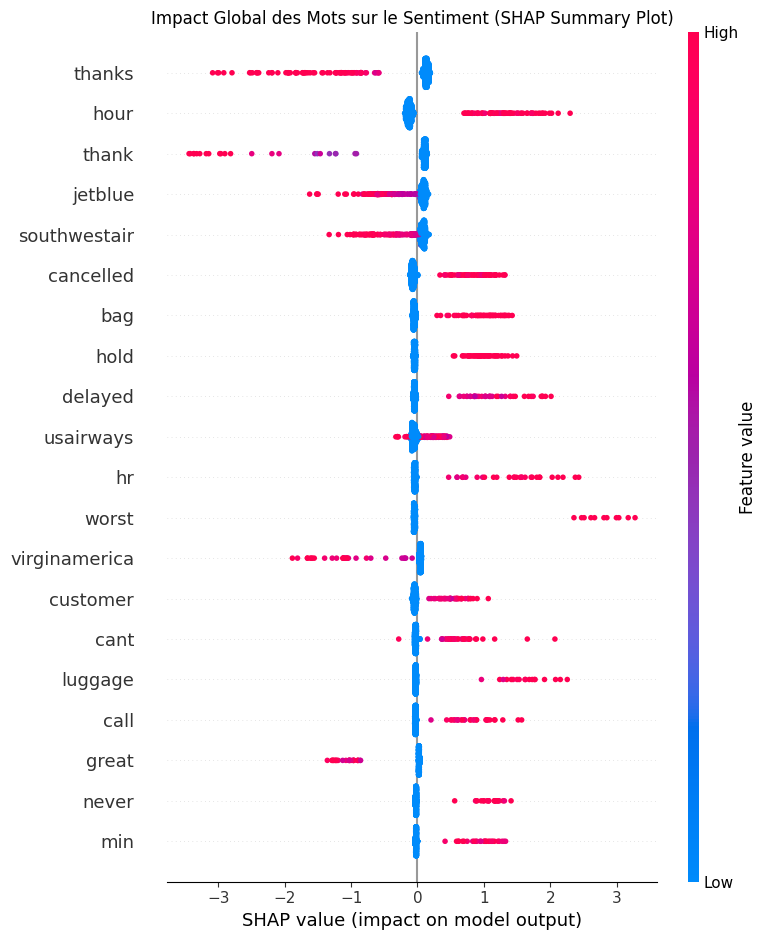


Interprétation du Summary Plot :
- Chaque ligne représente un mot (caractéristique). Les mots les plus importants sont en haut.
- L'axe horizontal indique la SHAP value du mot. Plus c'est à droite, plus le mot pousse vers le sentiment NÉGATIF.
- La couleur du point (de bleu à rouge) indique la valeur du mot TF-IDF pour l'observation :
  - Rouge : Le mot est très PRÉSENT et important dans le tweet (TF-IDF élevé).
  - Bleu : Le mot est moins présent (TF-IDF faible, mais s'il est là, il a quand même un impact).

--- Force Plot : Pourquoi un Tweet SPÉCIFIQUE est Négatif ? ---
Analyse d'un FAUX NÉGATIF (Index dans X_test/y_test : 41)
Tweet Original : "@SouthwestAir is this a sick joke? #toyingwithouremotions"
Tweet Nettoyé : "southwestair sick joke toyingwithouremotions"
Sentiment Réel : negative
Prédiction du Modèle : non-negative (probabilité négative : 0.36)


C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


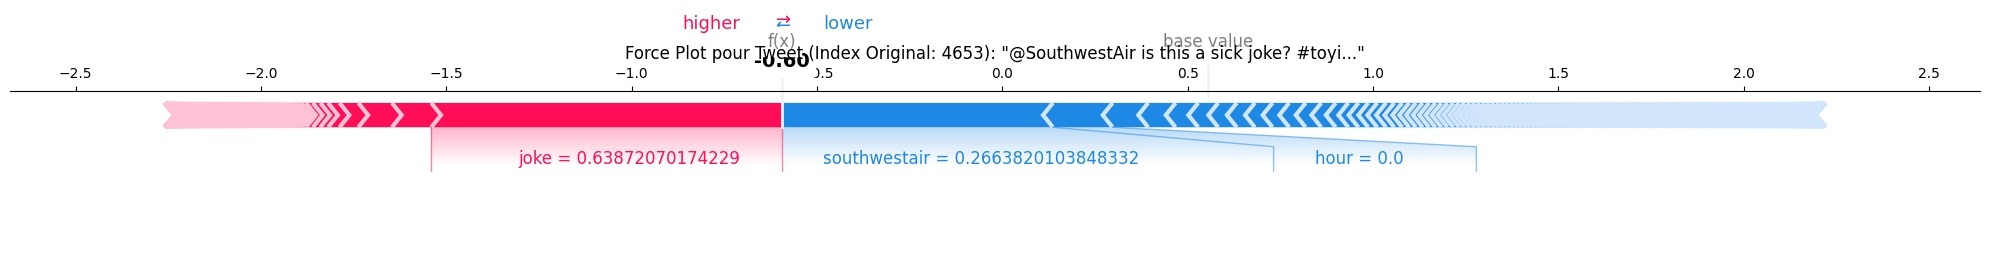


Interprétation du Force Plot :
- Les flèches rouges poussent la prédiction VERS LE HAUT (plus négatif).
- Les flèches bleues poussent la prédiction VERS LE BAS (moins négatif).
- Le début de la flèche est la 'base value' (probabilité moyenne de 'négatif').
- La fin de la flèche est la 'prédiction du modèle' pour ce tweet.
- Les mots (caractéristiques) sont affichés avec leur valeur (TF-IDF) et leur impact (flèche).

--- IA Explicable (XAI) Terminée pour le Sentiment ---


In [35]:
import shap
# --- DEBUT DU BLOC IA EXPLICABLE (qui utilise les variables précédentes) ---
print("\n--- Phase 4 : IA Explicable (XAI) pour l'Analyse de Sentiment ---")

# 1. Obtenir l'Explainer SHAP pour notre modèle LightGBM
explainer = shap.TreeExplainer(lgb_sentiment_model)

# --- CORRECTION ROBUSTE ICI pour l'échantillonnage des données SHAP ---
num_samples = 1000 # Nombre d'échantillons pour SHAP. Peut être augmenté à 5000 si RAM le permet.
np.random.seed(42) # Pour la reproductibilité

# 1. Sélectionner des indices aléatoires directement sur la plage de lignes de X_test
random_indices_for_shap_sample = np.random.choice(X_test.shape[0], num_samples, replace=False)

# 2. Calculer les SHAP Values sur un sous-ensemble des données de test
num_samples = 1000
np.random.seed(42)
random_indices_for_shap_sample = np.random.choice(X_test.shape[0], num_samples, replace=False)

sample_X_test_for_shap_dense = X_test[random_indices_for_shap_sample].toarray() # Convertir en dense ici


print(f"\nCalcul des SHAP values pour {sample_X_test_for_shap_dense.shape[0]} échantillons (peut prendre quelques minutes)...")

# Calculer les SHAP Values
shap_values_raw = explainer.shap_values(sample_X_test_for_shap_dense) # SHAP renvoie une liste de 2 arrays (pour classe 0 et 1)

# Assurer que shap_values_for_negative_class est une matrice 2D (num_samples, num_features)
# Si explainer.shap_values renvoie directement la matrice pour la classe 1 (typiquement array 2D)
# Si c'est une liste de 2 éléments [shap_values_class0, shap_values_class1], alors shap_values_raw[1] est le bon.
# Le problème se produit si shap_values_raw[1] est un vecteur 1D au lieu d'une matrice 2D.
if isinstance(shap_values_raw, list): # Si c'est une liste de SHAP values par classe
    shap_values_for_negative_class = shap_values_raw[1]
else: # Si c'est un array unique (peut arriver si le modèle a une seule classe de sortie ou est une régression)
    shap_values_for_negative_class = shap_values_raw

# Assurez-vous que c'est bien une matrice 2D même si SHAP la rend comme 1D par erreur.
# Si c'est un vecteur 1D, le remodeler en (num_samples, num_features)
if len(shap_values_for_negative_class.shape) == 1:
    shap_values_for_negative_class = shap_values_for_negative_class.reshape(num_samples, -1)


print("SHAP values calculées !")

# ... (Le reste du code reste le même, y compris le summary_plot et force_plot) ...

# 3. Visualisation de l'Impact Global (Summary Plot)
print("\n--- Summary Plot : Impact Global des Mots sur le Sentiment ---")
shap.initjs() # Initialiser JavaScript

plt.figure(figsize=(12, 8)) # Crée une figure Matplotlib
shap.summary_plot(
    shap_values_for_negative_class, # <--- Utiliser la variable après vérification de dimension
    sample_X_test_for_shap_dense, # Les données numériques (matrice dense) pour le plot
    feature_names=feature_names_for_shap, # Noms des caractéristiques (mots)
    plot_type="dot",
    show=False # On gère l'affichage avec plt.show()
)
plt.title('Impact Global des Mots sur le Sentiment (SHAP Summary Plot)')
plt.tight_layout()
plt.show()

print("\nInterprétation du Summary Plot :")
print("- Chaque ligne représente un mot (caractéristique). Les mots les plus importants sont en haut.")
print("- L'axe horizontal indique la SHAP value du mot. Plus c'est à droite, plus le mot pousse vers le sentiment NÉGATIF.")
print("- La couleur du point (de bleu à rouge) indique la valeur du mot TF-IDF pour l'observation :")
print("  - Rouge : Le mot est très PRÉSENT et important dans le tweet (TF-IDF élevé).")
print("  - Bleu : Le mot est moins présent (TF-IDF faible, mais s'il est là, il a quand même un impact).")


# --- Étape B : Explicabilité Locale (Force Plot pour un Tweet Spécifique) ---

print("\n--- Force Plot : Pourquoi un Tweet SPÉCIFIQUE est Négatif ? ---")

# Pour le Force Plot, on a besoin du texte original et de la prédiction réelle.
# Nous allons prendre un exemple DIRECTEMENT du test_df (non échantillonné par SHAP pour cette fois)
# pour éviter les problèmes d'indexation entre l'échantillon SHAP et le df_tweets original.
# C'est une approche plus simple pour le Force Plot car on ne le fait que sur 1 ligne.

# Choisissons un index dans X_test (par exemple, le premier Vrai Négatif ou Faux Négatif)
# Il faut que X_test_cls soit le DataFrame complet des features du test set (avant la transformation en csr_matrix pour X).
# y_test et y_pred doivent être les vraies valeurs et prédictions du test set complet.

# Trouver un index d'un tweet négatif réel (classe 1) pour l'analyse
# On peut chercher un Faux Négatif (modèle a dit 0, mais c'était 1) ou un Vrai Positif (modèle a dit 1, c'était 1)
# y_test et y_pred sont des np.array ou pd.Series qui ont la même longueur que X_test.

# Trouver les indices de Faux Négatifs (Vrai=1, Prédit=0) dans le y_test complet
fn_indices_in_full_test = np.where((y_test == 1) & (y_pred == 0))[0]

# Trouver les indices de Vrais Positifs (Vrai=1, Prédit=1)
tp_indices_in_full_test = np.where((y_test == 1) & (y_pred == 1))[0]

target_test_index = None # Index final dans X_test/y_test
if len(fn_indices_in_full_test) > 0:
    target_test_index = fn_indices_in_full_test[0] # Priorité aux Faux Négatifs (pour diagnostiquer une erreur)
    print(f"Analyse d'un FAUX NÉGATIF (Index dans X_test/y_test : {target_test_index})")
elif len(tp_indices_in_full_test) > 0:
    target_test_index = tp_indices_in_full_test[0] # Sinon, un Vrai Positif
    print(f"Analyse d'un VRAI POSITIF (Index dans X_test/y_test : {target_test_index})")
else:
    print("Pas de Faux Négatifs ou Vrais Positifs négatifs dans le jeu de test. Impossible de générer un Force Plot représentatif.")


if target_test_index is not None:
    # 1. Récupérer les données pour cette observation spécifique (de la matrice creuse)
    # Convertir en array dense pour SHAP pour cette seule ligne
    single_observation_X = X_test[target_test_index].toarray() # Convertit la ligne en array 2D

    # 2. Calculer les SHAP values pour cette seule observation
    single_shap_values = explainer.shap_values(single_observation_X)
    if isinstance(single_shap_values, list):
    # Pour un classifieur qui renvoie une liste de SHAP values par classe
        single_shap_values_for_negative_class = single_shap_values[1] # Prendre l'array pour la classe 1
    else:
    # Pour un régresseur ou un classifieur binaire qui renvoie directement l'array des SHAP values
        single_shap_values_for_negative_class = single_shap_values # L'array lui-même est ce dont on a besoin

    # 3. Récupérer le texte original et les détails du sentiment pour l'affichage
    # Les index de y_test sont les index d'origine dans df_tweets
    original_df_index = y_test.index[target_test_index] # L'index original dans df_tweets

    original_tweet_text = df_tweets.loc[original_df_index, 'text']
    cleaned_tweet_text = df_tweets.loc[original_df_index, 'processed_text_for_vectorizer']
    true_sentiment = df_tweets.loc[original_df_index, 'airline_sentiment']
    
    predicted_sentiment_prob = lgb_sentiment_model.predict_proba(single_observation_X)[0, 1]
    predicted_sentiment_label = "negative" if predicted_sentiment_prob > 0.5 else "non-negative"

    print(f"Tweet Original : \"{original_tweet_text}\"")
    print(f"Tweet Nettoyé : \"{cleaned_tweet_text}\"")
    print(f"Sentiment Réel : {true_sentiment}")
    print(f"Prédiction du Modèle : {predicted_sentiment_label} (probabilité négative : {predicted_sentiment_prob:.2f})")

    # 4. Visualiser le Force Plot
    if isinstance(explainer.expected_value, np.ndarray) and explainer.expected_value.ndim > 0:
    # Si c'est un array (e.g., [base_val_class0, base_val_class1]), prendre la base val de la classe 1.
       base_value_for_plot = explainer.expected_value[1]
    else:
    # Si c'est un scalaire direct (cas le plus probable pour binaire)
       base_value_for_plot = explainer.expected_value


    shap.force_plot(
        base_value_for_plot, # <--- UTILISER LA BASE VALUE CORRIGÉE ICI
        single_shap_values_for_negative_class[0], # SHAP values de la ligne
        single_observation_X[0], # Données de l'observation
        feature_names=feature_names_for_shap, # Noms des caractéristiques
        matplotlib=True,
        show=False
    )
    plt.title(f'Force Plot pour Tweet (Index Original: {original_df_index}): "{original_tweet_text[:40]}..."')
    plt.tight_layout()
    plt.show()

    print("\nInterprétation du Force Plot :")
    print("- Les flèches rouges poussent la prédiction VERS LE HAUT (plus négatif).")
    print("- Les flèches bleues poussent la prédiction VERS LE BAS (moins négatif).")
    print("- Le début de la flèche est la 'base value' (probabilité moyenne de 'négatif').")
    print("- La fin de la flèche est la 'prédiction du modèle' pour ce tweet.")
    print("- Les mots (caractéristiques) sont affichés avec leur valeur (TF-IDF) et leur impact (flèche).")

else:
    print("\nAucun index valide trouvé pour générer le Force Plot.")


print("\n--- IA Explicable (XAI) Terminée pour le Sentiment ---")
# --- FIN DU BLOC IA EXPLICABLE ---